# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [17]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-8, 5e-8, 1e-7, 2e-7, 5e-7]
regularization_strengths = [1e3, 5e4, 1e5, 5e5, 1e6, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
################################################################################
for learning_rate in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=learning_rate, reg=reg,
                      num_iters=3000, verbose=True)
        
        y_train_pred = svm.predict(X_train_feats)
        training_accuracy = np.mean(y_train == y_train_pred)
        
        y_val_pred = svm.predict(X_val_feats)
        validation_accuracy = np.mean(y_val == y_val_pred)
        
        results[(learning_rate, reg)] = (training_accuracy, validation_accuracy)
        
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm

################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 3000: loss 10.576027
iteration 100 / 3000: loss 10.571749
iteration 200 / 3000: loss 10.553060
iteration 300 / 3000: loss 10.554260
iteration 400 / 3000: loss 10.533839
iteration 500 / 3000: loss 10.540041
iteration 600 / 3000: loss 10.527622
iteration 700 / 3000: loss 10.519394
iteration 800 / 3000: loss 10.510460
iteration 900 / 3000: loss 10.521830
iteration 1000 / 3000: loss 10.498802
iteration 1100 / 3000: loss 10.486239
iteration 1200 / 3000: loss 10.486251
iteration 1300 / 3000: loss 10.489310
iteration 1400 / 3000: loss 10.470476
iteration 1500 / 3000: loss 10.481709
iteration 1600 / 3000: loss 10.478563
iteration 1700 / 3000: loss 10.446976
iteration 1800 / 3000: loss 10.471304
iteration 1900 / 3000: loss 10.455357
iteration 2000 / 3000: loss 10.447611
iteration 2100 / 3000: loss 10.439598
iteration 2200 / 3000: loss 10.444063
iteration 2300 / 3000: loss 10.422623
iteration 2400 / 3000: loss 10.411341
iteration 2500 / 3000: loss 10.416380
iteration 2600 / 3000: l

iteration 1200 / 3000: loss 9.000079
iteration 1300 / 3000: loss 8.999836
iteration 1400 / 3000: loss 8.999744
iteration 1500 / 3000: loss 8.999678
iteration 1600 / 3000: loss 8.999660
iteration 1700 / 3000: loss 8.999646
iteration 1800 / 3000: loss 8.999751
iteration 1900 / 3000: loss 8.999615
iteration 2000 / 3000: loss 8.999631
iteration 2100 / 3000: loss 8.999674
iteration 2200 / 3000: loss 8.999655
iteration 2300 / 3000: loss 8.999681
iteration 2400 / 3000: loss 8.999776
iteration 2500 / 3000: loss 8.999668
iteration 2600 / 3000: loss 8.999745
iteration 2700 / 3000: loss 8.999576
iteration 2800 / 3000: loss 8.999774
iteration 2900 / 3000: loss 8.999671
iteration 0 / 3000: loss 161.480474
iteration 100 / 3000: loss 29.429247
iteration 200 / 3000: loss 11.737004
iteration 300 / 3000: loss 9.366747
iteration 400 / 3000: loss 9.049175
iteration 500 / 3000: loss 9.006322
iteration 600 / 3000: loss 9.000714
iteration 700 / 3000: loss 8.999900
iteration 800 / 3000: loss 8.999838
iteratio

iteration 2500 / 3000: loss 8.999815
iteration 2600 / 3000: loss 8.999863
iteration 2700 / 3000: loss 8.999855
iteration 2800 / 3000: loss 8.999863
iteration 2900 / 3000: loss 8.999841
iteration 0 / 3000: loss 750.871232
iteration 100 / 3000: loss 8.999967
iteration 200 / 3000: loss 8.999975
iteration 300 / 3000: loss 8.999978
iteration 400 / 3000: loss 8.999965
iteration 500 / 3000: loss 8.999973
iteration 600 / 3000: loss 8.999961
iteration 700 / 3000: loss 8.999963
iteration 800 / 3000: loss 8.999970
iteration 900 / 3000: loss 8.999971
iteration 1000 / 3000: loss 8.999961
iteration 1100 / 3000: loss 8.999965
iteration 1200 / 3000: loss 8.999970
iteration 1300 / 3000: loss 8.999964
iteration 1400 / 3000: loss 8.999959
iteration 1500 / 3000: loss 8.999968
iteration 1600 / 3000: loss 8.999969
iteration 1700 / 3000: loss 8.999969
iteration 1800 / 3000: loss 8.999968
iteration 1900 / 3000: loss 8.999963
iteration 2000 / 3000: loss 8.999967
iteration 2100 / 3000: loss 8.999966
iteration 2

iteration 900 / 3000: loss 8.999987
iteration 1000 / 3000: loss 8.999988
iteration 1100 / 3000: loss 8.999988
iteration 1200 / 3000: loss 8.999990
iteration 1300 / 3000: loss 8.999988
iteration 1400 / 3000: loss 8.999987
iteration 1500 / 3000: loss 8.999984
iteration 1600 / 3000: loss 8.999989
iteration 1700 / 3000: loss 8.999982
iteration 1800 / 3000: loss 8.999988
iteration 1900 / 3000: loss 8.999988
iteration 2000 / 3000: loss 8.999985
iteration 2100 / 3000: loss 8.999988
iteration 2200 / 3000: loss 8.999989
iteration 2300 / 3000: loss 8.999989
iteration 2400 / 3000: loss 8.999984
iteration 2500 / 3000: loss 8.999984
iteration 2600 / 3000: loss 8.999990
iteration 2700 / 3000: loss 8.999989
iteration 2800 / 3000: loss 8.999991
iteration 2900 / 3000: loss 8.999985
iteration 0 / 3000: loss 7852.841766
iteration 100 / 3000: loss 7852.793661
iteration 200 / 3000: loss 7852.683151
iteration 300 / 3000: loss 7852.855527
iteration 400 / 3000: loss 7852.869308
iteration 500 / 3000: loss 7852

/Users/bavaria/Downloads/assignment1/cs231n/classifiers/linear_svm.py:84: RuntimeWarning: overflow encountered in double_scalars
  loss = np.sum(margins) / num_train + reg * np.sum(W * W)
/anaconda3/envs/cs231n/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/Users/bavaria/Downloads/assignment1/cs231n/classifiers/linear_svm.py:84: RuntimeWarning: overflow encountered in multiply
  loss = np.sum(margins) / num_train + reg * np.sum(W * W)


iteration 300 / 3000: loss inf
iteration 400 / 3000: loss inf
iteration 500 / 3000: loss inf


/Users/bavaria/Downloads/assignment1/cs231n/classifiers/linear_svm.py:107: RuntimeWarning: overflow encountered in multiply
  dW = dW / num_train + 2 * reg * W
/Users/bavaria/Downloads/assignment1/cs231n/classifiers/linear_svm.py:81: RuntimeWarning: invalid value encountered in less
  margins[np.where(margins < 0)] = 0
/Users/bavaria/Downloads/assignment1/cs231n/classifiers/linear_svm.py:103: RuntimeWarning: invalid value encountered in greater
  coefs[margins > 0] = 1
/Users/bavaria/Downloads/assignment1/cs231n/classifiers/linear_classifier.py:70: RuntimeWarning: invalid value encountered in add
  self.W += -learning_rate * grad


iteration 600 / 3000: loss nan
iteration 700 / 3000: loss nan
iteration 800 / 3000: loss nan
iteration 900 / 3000: loss nan
iteration 1000 / 3000: loss nan
iteration 1100 / 3000: loss nan
iteration 1200 / 3000: loss nan
iteration 1300 / 3000: loss nan
iteration 1400 / 3000: loss nan
iteration 1500 / 3000: loss nan
iteration 1600 / 3000: loss nan
iteration 1700 / 3000: loss nan
iteration 1800 / 3000: loss nan
iteration 1900 / 3000: loss nan
iteration 2000 / 3000: loss nan
iteration 2100 / 3000: loss nan
iteration 2200 / 3000: loss nan
iteration 2300 / 3000: loss nan
iteration 2400 / 3000: loss nan
iteration 2500 / 3000: loss nan
iteration 2600 / 3000: loss nan
iteration 2700 / 3000: loss nan
iteration 2800 / 3000: loss nan
iteration 2900 / 3000: loss nan
lr 1.000000e-08 reg 1.000000e+03 train accuracy: 0.096592 val accuracy: 0.086000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.118449 val accuracy: 0.136000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.287000 val accuracy: 0.

In [19]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.414


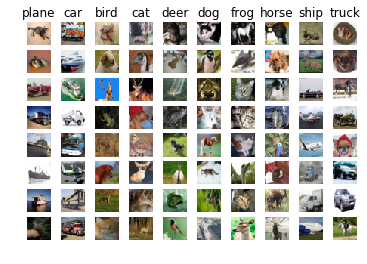

In [20]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [21]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [54]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_size = X_train_feats.shape[1]
hidden_sizes = [200, 500, 1000]
num_classes = 10

results = {}
best_net = None
best_val_acc = -1

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
batch_sizes = [100, 200, 400]
learning_rate_decays = [0.9, 0.95]
learning_rates = [2e-1, 5e-1, 0.9]
regs = [1e-3, 5e-3, 1e-2, 5e-2]
for hidden_size in hidden_sizes:
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            for learning_rate_decay in learning_rate_decays:
                for reg in regs:
                    net = TwoLayerNet(input_size, hidden_size, num_classes)
                    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                                num_iters=2000, batch_size=batch_size,
                                learning_rate=learning_rate, learning_rate_decay=learning_rate_decay,
                                reg=reg, verbose=True)

                    # Predict on the validation set
                    val_acc = (net.predict(X_val_feats) == y_val).mean()
                    print('Validation accuracy: ', val_acc)
                    
                    # Predict on the training set
                    train_acc = (net.predict(X_train_feats) == y_train).mean()
                    print('Training accuracy: ', train_acc)

                    results[(hidden_size, batch_size, learning_rate, learning_rate_decay, reg)] = (train_acc, val_acc)
                    
                    print((hidden_size, batch_size, learning_rate, learning_rate_decay, reg))
                    print((train_acc, val_acc))

                    if val_acc > best_val_acc:
                        best_val_acc = val_acc
                        best_net = net

                    print()

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 2.266678
iteration 200 / 2000: loss 1.718440
iteration 300 / 2000: loss 1.428954
iteration 400 / 2000: loss 1.389123
iteration 500 / 2000: loss 1.409281
iteration 600 / 2000: loss 1.180697
iteration 700 / 2000: loss 1.248969
iteration 800 / 2000: loss 1.475481
iteration 900 / 2000: loss 1.296407
iteration 1000 / 2000: loss 1.115983
iteration 1100 / 2000: loss 1.509158
iteration 1200 / 2000: loss 1.392790
iteration 1300 / 2000: loss 1.188220
iteration 1400 / 2000: loss 1.397843
iteration 1500 / 2000: loss 1.476319
iteration 1600 / 2000: loss 1.131343
iteration 1700 / 2000: loss 1.221368
iteration 1800 / 2000: loss 1.305828
iteration 1900 / 2000: loss 1.363110
Validation accuracy:  0.555
Training accuracy:  0.5883673469387755
(200, 100, 0.2, 0.9, 0.001)
(0.5883673469387755, 0.555)

iteration 0 / 2000: loss 2.302587
iteration 100 / 2000: loss 2.259200
iteration 200 / 2000: loss 1.836815
iteration 300 / 2000: loss 1.274134
iterat

iteration 1600 / 2000: loss 1.433373
iteration 1700 / 2000: loss 1.470842
iteration 1800 / 2000: loss 1.439225
iteration 1900 / 2000: loss 1.635908
Validation accuracy:  0.524
Training accuracy:  0.5511836734693878
(200, 100, 0.5, 0.9, 0.005)
(0.5511836734693878, 0.524)

iteration 0 / 2000: loss 2.302588
iteration 100 / 2000: loss 1.695592
iteration 200 / 2000: loss 1.734447
iteration 300 / 2000: loss 1.661228
iteration 400 / 2000: loss 1.656471
iteration 500 / 2000: loss 1.724258
iteration 600 / 2000: loss 1.785067
iteration 700 / 2000: loss 1.698150
iteration 800 / 2000: loss 1.713231
iteration 900 / 2000: loss 1.500026
iteration 1000 / 2000: loss 1.727162
iteration 1100 / 2000: loss 1.614399
iteration 1200 / 2000: loss 1.585124
iteration 1300 / 2000: loss 1.725537
iteration 1400 / 2000: loss 1.690962
iteration 1500 / 2000: loss 1.422944
iteration 1600 / 2000: loss 1.481915
iteration 1700 / 2000: loss 1.653631
iteration 1800 / 2000: loss 1.607943
iteration 1900 / 2000: loss 1.717306


iteration 800 / 2000: loss 2.040404
iteration 900 / 2000: loss 2.081224
iteration 1000 / 2000: loss 2.009772
iteration 1100 / 2000: loss 2.056034
iteration 1200 / 2000: loss 2.060168
iteration 1300 / 2000: loss 1.989686
iteration 1400 / 2000: loss 2.174803
iteration 1500 / 2000: loss 2.078146
iteration 1600 / 2000: loss 1.958014
iteration 1700 / 2000: loss 1.994694
iteration 1800 / 2000: loss 2.073511
iteration 1900 / 2000: loss 2.024014
Validation accuracy:  0.328
Training accuracy:  0.3513673469387755
(200, 100, 0.9, 0.9, 0.05)
(0.3513673469387755, 0.328)

iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 1.689109
iteration 200 / 2000: loss 1.518286
iteration 300 / 2000: loss 1.442600
iteration 400 / 2000: loss 1.601386
iteration 500 / 2000: loss 1.364706
iteration 600 / 2000: loss 1.416609
iteration 700 / 2000: loss 1.090625
iteration 800 / 2000: loss 1.447205
iteration 900 / 2000: loss 1.534814
iteration 1000 / 2000: loss 1.667322
iteration 1100 / 2000: loss 1.412815
ite

iteration 100 / 2000: loss 2.222930
iteration 200 / 2000: loss 1.749061
iteration 300 / 2000: loss 1.478532
iteration 400 / 2000: loss 1.596805
iteration 500 / 2000: loss 1.505253
iteration 600 / 2000: loss 1.551916
iteration 700 / 2000: loss 1.483800
iteration 800 / 2000: loss 1.434384
iteration 900 / 2000: loss 1.489963
iteration 1000 / 2000: loss 1.549211
iteration 1100 / 2000: loss 1.436585
iteration 1200 / 2000: loss 1.416572
iteration 1300 / 2000: loss 1.391999
iteration 1400 / 2000: loss 1.454812
iteration 1500 / 2000: loss 1.491612
iteration 1600 / 2000: loss 1.536515
iteration 1700 / 2000: loss 1.446540
iteration 1800 / 2000: loss 1.377902
iteration 1900 / 2000: loss 1.367948
Validation accuracy:  0.537
Training accuracy:  0.5530612244897959
(200, 200, 0.2, 0.95, 0.005)
(0.5530612244897959, 0.537)

iteration 0 / 2000: loss 2.302588
iteration 100 / 2000: loss 2.227589
iteration 200 / 2000: loss 1.847236
iteration 300 / 2000: loss 1.648166
iteration 400 / 2000: loss 1.566393
ite

iteration 1600 / 2000: loss 1.403531
iteration 1700 / 2000: loss 1.475368
iteration 1800 / 2000: loss 1.539953
iteration 1900 / 2000: loss 1.593640
Validation accuracy:  0.52
Training accuracy:  0.522469387755102
(200, 200, 0.5, 0.95, 0.01)
(0.522469387755102, 0.52)

iteration 0 / 2000: loss 2.302601
iteration 100 / 2000: loss 2.035613
iteration 200 / 2000: loss 1.930036
iteration 300 / 2000: loss 2.017283
iteration 400 / 2000: loss 1.959248
iteration 500 / 2000: loss 1.978550
iteration 600 / 2000: loss 1.985080
iteration 700 / 2000: loss 1.973977
iteration 800 / 2000: loss 2.022803
iteration 900 / 2000: loss 1.990439
iteration 1000 / 2000: loss 1.934559
iteration 1100 / 2000: loss 1.968968
iteration 1200 / 2000: loss 1.988326
iteration 1300 / 2000: loss 1.926008
iteration 1400 / 2000: loss 1.963585
iteration 1500 / 2000: loss 1.970426
iteration 1600 / 2000: loss 1.990488
iteration 1700 / 2000: loss 1.997710
iteration 1800 / 2000: loss 1.982822
iteration 1900 / 2000: loss 1.951797
Vali

iteration 800 / 2000: loss 1.314685
iteration 900 / 2000: loss 1.313917
iteration 1000 / 2000: loss 1.308768
iteration 1100 / 2000: loss 1.355499
iteration 1200 / 2000: loss 1.248040
iteration 1300 / 2000: loss 1.251083
iteration 1400 / 2000: loss 1.244797
iteration 1500 / 2000: loss 1.368420
iteration 1600 / 2000: loss 1.331864
iteration 1700 / 2000: loss 1.312551
iteration 1800 / 2000: loss 1.269221
iteration 1900 / 2000: loss 1.240047
Validation accuracy:  0.558
Training accuracy:  0.591
(200, 400, 0.2, 0.9, 0.001)
(0.591, 0.558)

iteration 0 / 2000: loss 2.302587
iteration 100 / 2000: loss 2.255642
iteration 200 / 2000: loss 1.756400
iteration 300 / 2000: loss 1.534491
iteration 400 / 2000: loss 1.507289
iteration 500 / 2000: loss 1.503389
iteration 600 / 2000: loss 1.509395
iteration 700 / 2000: loss 1.426576
iteration 800 / 2000: loss 1.533240
iteration 900 / 2000: loss 1.475786
iteration 1000 / 2000: loss 1.371274
iteration 1100 / 2000: loss 1.499161
iteration 1200 / 2000: loss 

iteration 100 / 2000: loss 1.735511
iteration 200 / 2000: loss 1.537005
iteration 300 / 2000: loss 1.630961
iteration 400 / 2000: loss 1.553095
iteration 500 / 2000: loss 1.597708
iteration 600 / 2000: loss 1.629623
iteration 700 / 2000: loss 1.513245
iteration 800 / 2000: loss 1.593208
iteration 900 / 2000: loss 1.534350
iteration 1000 / 2000: loss 1.648590
iteration 1100 / 2000: loss 1.486183
iteration 1200 / 2000: loss 1.583979
iteration 1300 / 2000: loss 1.552062
iteration 1400 / 2000: loss 1.539475
iteration 1500 / 2000: loss 1.418694
iteration 1600 / 2000: loss 1.503784
iteration 1700 / 2000: loss 1.538728
iteration 1800 / 2000: loss 1.545378
iteration 1900 / 2000: loss 1.539120
Validation accuracy:  0.516
Training accuracy:  0.5304285714285715
(200, 400, 0.5, 0.9, 0.01)
(0.5304285714285715, 0.516)

iteration 0 / 2000: loss 2.302602
iteration 100 / 2000: loss 2.099062
iteration 200 / 2000: loss 1.926840
iteration 300 / 2000: loss 2.028311
iteration 400 / 2000: loss 1.930468
itera

iteration 1600 / 2000: loss 1.968761
iteration 1700 / 2000: loss 1.950537
iteration 1800 / 2000: loss 1.987049
iteration 1900 / 2000: loss 1.879759
Validation accuracy:  0.422
Training accuracy:  0.41255102040816327
(200, 400, 0.9, 0.9, 0.05)
(0.41255102040816327, 0.422)

iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 1.489036
iteration 200 / 2000: loss 1.304210
iteration 300 / 2000: loss 1.403383
iteration 400 / 2000: loss 1.304197
iteration 500 / 2000: loss 1.183099
iteration 600 / 2000: loss 1.145981
iteration 700 / 2000: loss 1.157675
iteration 800 / 2000: loss 1.127215
iteration 900 / 2000: loss 1.179548
iteration 1000 / 2000: loss 1.078080
iteration 1100 / 2000: loss 1.253923
iteration 1200 / 2000: loss 1.155422
iteration 1300 / 2000: loss 1.062843
iteration 1400 / 2000: loss 1.148663
iteration 1500 / 2000: loss 1.162919
iteration 1600 / 2000: loss 1.124966
iteration 1700 / 2000: loss 1.211034
iteration 1800 / 2000: loss 1.234369
iteration 1900 / 2000: loss 1.089525

iteration 800 / 2000: loss 1.436070
iteration 900 / 2000: loss 1.268925
iteration 1000 / 2000: loss 1.469813
iteration 1100 / 2000: loss 1.325580
iteration 1200 / 2000: loss 1.579037
iteration 1300 / 2000: loss 1.570420
iteration 1400 / 2000: loss 1.393155
iteration 1500 / 2000: loss 1.614489
iteration 1600 / 2000: loss 1.506597
iteration 1700 / 2000: loss 1.482973
iteration 1800 / 2000: loss 1.407882
iteration 1900 / 2000: loss 1.485014
Validation accuracy:  0.526
Training accuracy:  0.5482448979591836
(500, 100, 0.2, 0.95, 0.005)
(0.5482448979591836, 0.526)

iteration 0 / 2000: loss 2.302593
iteration 100 / 2000: loss 2.213328
iteration 200 / 2000: loss 1.852670
iteration 300 / 2000: loss 1.715482
iteration 400 / 2000: loss 1.612265
iteration 500 / 2000: loss 1.822408
iteration 600 / 2000: loss 1.545826
iteration 700 / 2000: loss 1.365578
iteration 800 / 2000: loss 1.654867
iteration 900 / 2000: loss 1.687522
iteration 1000 / 2000: loss 1.585360
iteration 1100 / 2000: loss 1.467678
i

iteration 100 / 2000: loss 2.037075
iteration 200 / 2000: loss 2.009170
iteration 300 / 2000: loss 2.102258
iteration 400 / 2000: loss 1.992310
iteration 500 / 2000: loss 1.968917
iteration 600 / 2000: loss 1.940031
iteration 700 / 2000: loss 2.093272
iteration 800 / 2000: loss 1.966554
iteration 900 / 2000: loss 2.038410
iteration 1000 / 2000: loss 2.110874
iteration 1100 / 2000: loss 1.968984
iteration 1200 / 2000: loss 1.992786
iteration 1300 / 2000: loss 2.126324
iteration 1400 / 2000: loss 2.082578
iteration 1500 / 2000: loss 2.080249
iteration 1600 / 2000: loss 1.983507
iteration 1700 / 2000: loss 1.848587
iteration 1800 / 2000: loss 1.981690
iteration 1900 / 2000: loss 1.985274
Validation accuracy:  0.378
Training accuracy:  0.4024285714285714
(500, 100, 0.5, 0.95, 0.05)
(0.4024285714285714, 0.378)

iteration 0 / 2000: loss 2.302586
iteration 100 / 2000: loss 1.628151
iteration 200 / 2000: loss 1.551755
iteration 300 / 2000: loss 1.330696
iteration 400 / 2000: loss 1.333598
iter

iteration 1600 / 2000: loss 1.330696
iteration 1700 / 2000: loss 1.172797
iteration 1800 / 2000: loss 1.201385
iteration 1900 / 2000: loss 1.319023
Validation accuracy:  0.57
Training accuracy:  0.5915510204081633
(500, 200, 0.2, 0.9, 0.001)
(0.5915510204081633, 0.57)

iteration 0 / 2000: loss 2.302589
iteration 100 / 2000: loss 2.254278
iteration 200 / 2000: loss 1.704752
iteration 300 / 2000: loss 1.548344
iteration 400 / 2000: loss 1.525518
iteration 500 / 2000: loss 1.498495
iteration 600 / 2000: loss 1.481000
iteration 700 / 2000: loss 1.418046
iteration 800 / 2000: loss 1.583789
iteration 900 / 2000: loss 1.429863
iteration 1000 / 2000: loss 1.401292
iteration 1100 / 2000: loss 1.485072
iteration 1200 / 2000: loss 1.442161
iteration 1300 / 2000: loss 1.440074
iteration 1400 / 2000: loss 1.520008
iteration 1500 / 2000: loss 1.428952
iteration 1600 / 2000: loss 1.380953
iteration 1700 / 2000: loss 1.450295
iteration 1800 / 2000: loss 1.500261
iteration 1900 / 2000: loss 1.429031
Va

iteration 800 / 2000: loss 1.549344
iteration 900 / 2000: loss 1.501611
iteration 1000 / 2000: loss 1.676596
iteration 1100 / 2000: loss 1.628223
iteration 1200 / 2000: loss 1.581157
iteration 1300 / 2000: loss 1.491000
iteration 1400 / 2000: loss 1.642451
iteration 1500 / 2000: loss 1.672369
iteration 1600 / 2000: loss 1.585491
iteration 1700 / 2000: loss 1.679458
iteration 1800 / 2000: loss 1.632682
iteration 1900 / 2000: loss 1.528767
Validation accuracy:  0.506
Training accuracy:  0.5293265306122449
(500, 200, 0.5, 0.9, 0.01)
(0.5293265306122449, 0.506)

iteration 0 / 2000: loss 2.302626
iteration 100 / 2000: loss 2.075392
iteration 200 / 2000: loss 2.093470
iteration 300 / 2000: loss 1.951629
iteration 400 / 2000: loss 1.994705
iteration 500 / 2000: loss 1.988137
iteration 600 / 2000: loss 1.933457
iteration 700 / 2000: loss 1.923793
iteration 800 / 2000: loss 2.020215
iteration 900 / 2000: loss 1.972681
iteration 1000 / 2000: loss 2.065407
iteration 1100 / 2000: loss 2.041262
ite

iteration 100 / 2000: loss 1.424681
iteration 200 / 2000: loss 1.371972
iteration 300 / 2000: loss 1.421322
iteration 400 / 2000: loss 1.455611
iteration 500 / 2000: loss 1.353297
iteration 600 / 2000: loss 1.285126
iteration 700 / 2000: loss 1.210970
iteration 800 / 2000: loss 1.236430
iteration 900 / 2000: loss 1.216667
iteration 1000 / 2000: loss 1.181207
iteration 1100 / 2000: loss 1.157007
iteration 1200 / 2000: loss 1.315941
iteration 1300 / 2000: loss 1.188174
iteration 1400 / 2000: loss 1.231069
iteration 1500 / 2000: loss 1.411590
iteration 1600 / 2000: loss 1.136777
iteration 1700 / 2000: loss 1.263166
iteration 1800 / 2000: loss 1.084319
iteration 1900 / 2000: loss 1.177866
Validation accuracy:  0.587
Training accuracy:  0.6834897959183673
(500, 200, 0.9, 0.95, 0.001)
(0.6834897959183673, 0.587)

iteration 0 / 2000: loss 2.302589
iteration 100 / 2000: loss 1.524972
iteration 200 / 2000: loss 1.681649
iteration 300 / 2000: loss 1.502445
iteration 400 / 2000: loss 1.515985
ite

iteration 1600 / 2000: loss 1.390895
iteration 1700 / 2000: loss 1.391459
iteration 1800 / 2000: loss 1.451333
iteration 1900 / 2000: loss 1.364381
Validation accuracy:  0.547
Training accuracy:  0.5591836734693878
(500, 400, 0.2, 0.95, 0.005)
(0.5591836734693878, 0.547)

iteration 0 / 2000: loss 2.302593
iteration 100 / 2000: loss 2.195809
iteration 200 / 2000: loss 1.786585
iteration 300 / 2000: loss 1.642988
iteration 400 / 2000: loss 1.570774
iteration 500 / 2000: loss 1.668734
iteration 600 / 2000: loss 1.508973
iteration 700 / 2000: loss 1.578598
iteration 800 / 2000: loss 1.578329
iteration 900 / 2000: loss 1.573387
iteration 1000 / 2000: loss 1.565076
iteration 1100 / 2000: loss 1.510561
iteration 1200 / 2000: loss 1.587400
iteration 1300 / 2000: loss 1.542811
iteration 1400 / 2000: loss 1.649851
iteration 1500 / 2000: loss 1.557048
iteration 1600 / 2000: loss 1.543703
iteration 1700 / 2000: loss 1.572244
iteration 1800 / 2000: loss 1.526558
iteration 1900 / 2000: loss 1.472458

iteration 800 / 2000: loss 1.930295
iteration 900 / 2000: loss 2.034093
iteration 1000 / 2000: loss 1.948770
iteration 1100 / 2000: loss 2.008012
iteration 1200 / 2000: loss 1.952590
iteration 1300 / 2000: loss 1.912932
iteration 1400 / 2000: loss 1.912073
iteration 1500 / 2000: loss 1.982534
iteration 1600 / 2000: loss 1.983053
iteration 1700 / 2000: loss 1.956201
iteration 1800 / 2000: loss 1.988112
iteration 1900 / 2000: loss 2.017045
Validation accuracy:  0.423
Training accuracy:  0.4370816326530612
(500, 400, 0.5, 0.95, 0.05)
(0.4370816326530612, 0.423)

iteration 0 / 2000: loss 2.302586
iteration 100 / 2000: loss 1.461390
iteration 200 / 2000: loss 1.268926
iteration 300 / 2000: loss 1.319650
iteration 400 / 2000: loss 1.176134
iteration 500 / 2000: loss 1.301569
iteration 600 / 2000: loss 1.216222
iteration 700 / 2000: loss 1.169002
iteration 800 / 2000: loss 1.183175
iteration 900 / 2000: loss 1.208321
iteration 1000 / 2000: loss 1.041467
iteration 1100 / 2000: loss 1.119903
it

iteration 100 / 2000: loss 2.173942
iteration 200 / 2000: loss 1.809016
iteration 300 / 2000: loss 1.544449
iteration 400 / 2000: loss 1.673342
iteration 500 / 2000: loss 1.399084
iteration 600 / 2000: loss 1.523000
iteration 700 / 2000: loss 1.541838
iteration 800 / 2000: loss 1.511224
iteration 900 / 2000: loss 1.445720
iteration 1000 / 2000: loss 1.383699
iteration 1100 / 2000: loss 1.566913
iteration 1200 / 2000: loss 1.389665
iteration 1300 / 2000: loss 1.414524
iteration 1400 / 2000: loss 1.403845
iteration 1500 / 2000: loss 1.531425
iteration 1600 / 2000: loss 1.403231
iteration 1700 / 2000: loss 1.259313
iteration 1800 / 2000: loss 1.367126
iteration 1900 / 2000: loss 1.410598
Validation accuracy:  0.548
Training accuracy:  0.5529387755102041
(1000, 100, 0.2, 0.9, 0.005)
(0.5529387755102041, 0.548)

iteration 0 / 2000: loss 2.302602
iteration 100 / 2000: loss 2.215533
iteration 200 / 2000: loss 1.890013
iteration 300 / 2000: loss 1.634588
iteration 400 / 2000: loss 1.625224
ite

iteration 1600 / 2000: loss 1.564145
iteration 1700 / 2000: loss 1.630683
iteration 1800 / 2000: loss 1.578668
iteration 1900 / 2000: loss 1.640699
Validation accuracy:  0.498
Training accuracy:  0.5073877551020408
(1000, 100, 0.5, 0.9, 0.01)
(0.5073877551020408, 0.498)

iteration 0 / 2000: loss 2.302667
iteration 100 / 2000: loss 2.067778
iteration 200 / 2000: loss 1.983147
iteration 300 / 2000: loss 1.922009
iteration 400 / 2000: loss 2.035156
iteration 500 / 2000: loss 2.088275
iteration 600 / 2000: loss 2.067309
iteration 700 / 2000: loss 1.962987
iteration 800 / 2000: loss 1.994512
iteration 900 / 2000: loss 1.869162
iteration 1000 / 2000: loss 2.045355
iteration 1100 / 2000: loss 1.993665
iteration 1200 / 2000: loss 1.939462
iteration 1300 / 2000: loss 2.076429
iteration 1400 / 2000: loss 1.952879
iteration 1500 / 2000: loss 1.931933
iteration 1600 / 2000: loss 2.055272
iteration 1700 / 2000: loss 2.006173
iteration 1800 / 2000: loss 2.008642
iteration 1900 / 2000: loss 2.006799


iteration 700 / 2000: loss 1.652622
iteration 800 / 2000: loss 1.375958
iteration 900 / 2000: loss 1.554745
iteration 1000 / 2000: loss 1.493326
iteration 1100 / 2000: loss 1.506694
iteration 1200 / 2000: loss 1.411998
iteration 1300 / 2000: loss 1.384971
iteration 1400 / 2000: loss 1.529605
iteration 1500 / 2000: loss 1.475872
iteration 1600 / 2000: loss 1.319067
iteration 1700 / 2000: loss 1.256566
iteration 1800 / 2000: loss 1.341268
iteration 1900 / 2000: loss 1.334880
Validation accuracy:  0.56
Training accuracy:  0.6321428571428571
(1000, 100, 0.9, 0.95, 0.001)
(0.6321428571428571, 0.56)

iteration 0 / 2000: loss 2.302593
iteration 100 / 2000: loss 1.748431
iteration 200 / 2000: loss 1.712304
iteration 300 / 2000: loss 1.717268
iteration 400 / 2000: loss 1.528689
iteration 500 / 2000: loss 1.701502
iteration 600 / 2000: loss 1.711980
iteration 700 / 2000: loss 1.602573
iteration 800 / 2000: loss 1.732763
iteration 900 / 2000: loss 1.720197
iteration 1000 / 2000: loss 1.650820
ite

iteration 100 / 2000: loss 2.168580
iteration 200 / 2000: loss 1.801271
iteration 300 / 2000: loss 1.685027
iteration 400 / 2000: loss 1.604736
iteration 500 / 2000: loss 1.572254
iteration 600 / 2000: loss 1.633687
iteration 700 / 2000: loss 1.563219
iteration 800 / 2000: loss 1.566805
iteration 900 / 2000: loss 1.605403
iteration 1000 / 2000: loss 1.536449
iteration 1100 / 2000: loss 1.624316
iteration 1200 / 2000: loss 1.541847
iteration 1300 / 2000: loss 1.551035
iteration 1400 / 2000: loss 1.525251
iteration 1500 / 2000: loss 1.528547
iteration 1600 / 2000: loss 1.504578
iteration 1700 / 2000: loss 1.523657
iteration 1800 / 2000: loss 1.556734
iteration 1900 / 2000: loss 1.572582
Validation accuracy:  0.508
Training accuracy:  0.5265510204081633
(1000, 200, 0.2, 0.95, 0.01)
(0.5265510204081633, 0.508)

iteration 0 / 2000: loss 2.302667
iteration 100 / 2000: loss 2.295400
iteration 200 / 2000: loss 2.066808
iteration 300 / 2000: loss 2.093115
iteration 400 / 2000: loss 2.059989
ite

iteration 1600 / 2000: loss 1.927405
iteration 1700 / 2000: loss 1.985066
iteration 1800 / 2000: loss 1.951565
iteration 1900 / 2000: loss 1.983961
Validation accuracy:  0.409
Training accuracy:  0.4097142857142857
(1000, 200, 0.5, 0.95, 0.05)
(0.4097142857142857, 0.409)

iteration 0 / 2000: loss 2.302586
iteration 100 / 2000: loss 1.387763
iteration 200 / 2000: loss 1.351828
iteration 300 / 2000: loss 1.301571
iteration 400 / 2000: loss 1.173950
iteration 500 / 2000: loss 1.326727
iteration 600 / 2000: loss 1.250497
iteration 700 / 2000: loss 1.179135
iteration 800 / 2000: loss 1.161860
iteration 900 / 2000: loss 1.179393
iteration 1000 / 2000: loss 1.196132
iteration 1100 / 2000: loss 1.165402
iteration 1200 / 2000: loss 1.114610
iteration 1300 / 2000: loss 1.076056
iteration 1400 / 2000: loss 1.114615
iteration 1500 / 2000: loss 1.011874
iteration 1600 / 2000: loss 1.080314
iteration 1700 / 2000: loss 1.066893
iteration 1800 / 2000: loss 1.210362
iteration 1900 / 2000: loss 1.144390

iteration 700 / 2000: loss 1.460944
iteration 800 / 2000: loss 1.452483
iteration 900 / 2000: loss 1.457369
iteration 1000 / 2000: loss 1.492818
iteration 1100 / 2000: loss 1.482082
iteration 1200 / 2000: loss 1.366932
iteration 1300 / 2000: loss 1.420665
iteration 1400 / 2000: loss 1.389258
iteration 1500 / 2000: loss 1.440642
iteration 1600 / 2000: loss 1.512074
iteration 1700 / 2000: loss 1.422074
iteration 1800 / 2000: loss 1.403445
iteration 1900 / 2000: loss 1.409364
Validation accuracy:  0.546
Training accuracy:  0.5515714285714286
(1000, 400, 0.2, 0.9, 0.005)
(0.5515714285714286, 0.546)

iteration 0 / 2000: loss 2.302602
iteration 100 / 2000: loss 2.193460
iteration 200 / 2000: loss 1.780917
iteration 300 / 2000: loss 1.629593
iteration 400 / 2000: loss 1.612211
iteration 500 / 2000: loss 1.449721
iteration 600 / 2000: loss 1.632449
iteration 700 / 2000: loss 1.510318
iteration 800 / 2000: loss 1.565840
iteration 900 / 2000: loss 1.520145
iteration 1000 / 2000: loss 1.578838
it

iteration 100 / 2000: loss 2.074861
iteration 200 / 2000: loss 2.001339
iteration 300 / 2000: loss 2.033343
iteration 400 / 2000: loss 1.956138
iteration 500 / 2000: loss 1.940634
iteration 600 / 2000: loss 1.958570
iteration 700 / 2000: loss 1.951534
iteration 800 / 2000: loss 1.910546
iteration 900 / 2000: loss 1.953553
iteration 1000 / 2000: loss 1.926265
iteration 1100 / 2000: loss 1.969780
iteration 1200 / 2000: loss 1.909342
iteration 1300 / 2000: loss 1.897299
iteration 1400 / 2000: loss 1.973842
iteration 1500 / 2000: loss 1.936391
iteration 1600 / 2000: loss 1.950066
iteration 1700 / 2000: loss 1.914657
iteration 1800 / 2000: loss 1.961400
iteration 1900 / 2000: loss 1.979762
Validation accuracy:  0.451
Training accuracy:  0.43679591836734694
(1000, 400, 0.5, 0.9, 0.05)
(0.43679591836734694, 0.451)

iteration 0 / 2000: loss 2.302587
iteration 100 / 2000: loss 1.511099
iteration 200 / 2000: loss 1.374645
iteration 300 / 2000: loss 1.373548
iteration 400 / 2000: loss 1.312958
it

iteration 1600 / 2000: loss 1.058113
iteration 1700 / 2000: loss 1.059383
iteration 1800 / 2000: loss 1.092907
iteration 1900 / 2000: loss 1.079755
Validation accuracy:  0.589
Training accuracy:  0.7503877551020408
(1000, 400, 0.9, 0.95, 0.001)
(0.7503877551020408, 0.589)

iteration 0 / 2000: loss 2.302593
iteration 100 / 2000: loss 1.500381
iteration 200 / 2000: loss 1.583915
iteration 300 / 2000: loss 1.428548
iteration 400 / 2000: loss 1.436735
iteration 500 / 2000: loss 1.461369
iteration 600 / 2000: loss 1.370147
iteration 700 / 2000: loss 1.417153
iteration 800 / 2000: loss 1.447253
iteration 900 / 2000: loss 1.439953
iteration 1000 / 2000: loss 1.403249
iteration 1100 / 2000: loss 1.431648
iteration 1200 / 2000: loss 1.486440
iteration 1300 / 2000: loss 1.459411
iteration 1400 / 2000: loss 1.460499
iteration 1500 / 2000: loss 1.385042
iteration 1600 / 2000: loss 1.464378
iteration 1700 / 2000: loss 1.492892
iteration 1800 / 2000: loss 1.437464
iteration 1900 / 2000: loss 1.47716

In [60]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.577


In [58]:
a = {}
for k,v in results.items():
    if len(k) > 2:
        a[k] = v[1]

In [59]:
from operator import itemgetter
sorted(a.items(), key=itemgetter(1))

[((500, 100, 0.9, 0.9, 0.05), 0.299),
 ((200, 100, 0.9, 0.9, 0.05), 0.328),
 ((500, 100, 0.9, 0.95, 0.05), 0.35),
 ((500, 200, 0.9, 0.95, 0.05), 0.365),
 ((200, 200, 0.9, 0.95, 0.05), 0.374),
 ((1000, 100, 0.9, 0.9, 0.05), 0.375),
 ((500, 400, 0.9, 0.95, 0.05), 0.377),
 ((500, 100, 0.5, 0.95, 0.05), 0.378),
 ((200, 100, 0.9, 0.95, 0.05), 0.379),
 ((1000, 100, 0.9, 0.95, 0.05), 0.38),
 ((1000, 100, 0.5, 0.95, 0.05), 0.382),
 ((200, 100, 0.5, 0.9, 0.05), 0.388),
 ((1000, 400, 0.9, 0.95, 0.05), 0.392),
 ((200, 100, 0.5, 0.95, 0.05), 0.394),
 ((500, 200, 0.5, 0.95, 0.05), 0.395),
 ((500, 200, 0.2, 0.95, 0.05), 0.396),
 ((200, 400, 0.5, 0.95, 0.05), 0.401),
 ((500, 100, 0.2, 0.9, 0.05), 0.403),
 ((200, 100, 0.2, 0.95, 0.05), 0.404),
 ((1000, 200, 0.9, 0.9, 0.05), 0.404),
 ((1000, 400, 0.5, 0.95, 0.05), 0.408),
 ((200, 200, 0.2, 0.95, 0.05), 0.409),
 ((1000, 200, 0.5, 0.9, 0.05), 0.409),
 ((1000, 200, 0.5, 0.95, 0.05), 0.409),
 ((200, 200, 0.5, 0.95, 0.05), 0.41),
 ((1000, 100, 0.5, 0.9, 0.0

In [61]:
hidden_sizes = 500

learning_rate_decays = [0.9, 0.95]
learning_rates = [0.4, 0.5, 0.6, 0.7]
regs = [9e-4, 1e-3, 2e-3]

results2 = {}
best_net2 = None
best_val_acc2 = -1

for learning_rate in learning_rates:
    for learning_rate_decay in learning_rate_decays:
        for reg in regs:
            net = TwoLayerNet(input_size, hidden_size, num_classes)
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                        num_iters=2500, batch_size=200,
                        learning_rate=learning_rate, learning_rate_decay=learning_rate_decay,
                        reg=reg, verbose=True)

            # Predict on the validation set
            val_acc = (net.predict(X_val_feats) == y_val).mean()
            print('Validation accuracy: ', val_acc)

            # Predict on the training set
            train_acc = (net.predict(X_train_feats) == y_train).mean()
            print('Training accuracy: ', train_acc)

            results2[(learning_rate, learning_rate_decay, reg)] = (train_acc, val_acc)

            print((learning_rate, learning_rate_decay, reg))
            print((train_acc, val_acc))

            if val_acc > best_val_acc2:
                best_val_acc2 = val_acc
                best_net2 = net

            print()

iteration 0 / 2500: loss 2.302586
iteration 100 / 2500: loss 1.560333
iteration 200 / 2500: loss 1.395993
iteration 300 / 2500: loss 1.532289
iteration 400 / 2500: loss 1.329300
iteration 500 / 2500: loss 1.322620
iteration 600 / 2500: loss 1.285591
iteration 700 / 2500: loss 1.196081
iteration 800 / 2500: loss 1.207253
iteration 900 / 2500: loss 1.212414
iteration 1000 / 2500: loss 1.245502
iteration 1100 / 2500: loss 1.078017
iteration 1200 / 2500: loss 1.138373
iteration 1300 / 2500: loss 1.144640
iteration 1400 / 2500: loss 1.178995
iteration 1500 / 2500: loss 1.039444
iteration 1600 / 2500: loss 1.107834
iteration 1700 / 2500: loss 1.150058
iteration 1800 / 2500: loss 1.123811
iteration 1900 / 2500: loss 1.258223
iteration 2000 / 2500: loss 1.117626
iteration 2100 / 2500: loss 1.027641
iteration 2200 / 2500: loss 1.090622
iteration 2300 / 2500: loss 1.038326
iteration 2400 / 2500: loss 0.969922
Validation accuracy:  0.575
Training accuracy:  0.6883877551020409
(0.4, 0.9, 0.0009)
(

iteration 100 / 2500: loss 1.555925
iteration 200 / 2500: loss 1.349094
iteration 300 / 2500: loss 1.269461
iteration 400 / 2500: loss 1.350585
iteration 500 / 2500: loss 1.280836
iteration 600 / 2500: loss 1.402948
iteration 700 / 2500: loss 1.250068
iteration 800 / 2500: loss 1.366596
iteration 900 / 2500: loss 1.380851
iteration 1000 / 2500: loss 1.320776
iteration 1100 / 2500: loss 1.257994
iteration 1200 / 2500: loss 1.335058
iteration 1300 / 2500: loss 1.327314
iteration 1400 / 2500: loss 1.183312
iteration 1500 / 2500: loss 1.215337
iteration 1600 / 2500: loss 1.246126
iteration 1700 / 2500: loss 1.253321
iteration 1800 / 2500: loss 1.375250
iteration 1900 / 2500: loss 1.218090
iteration 2000 / 2500: loss 1.279346
iteration 2100 / 2500: loss 1.182218
iteration 2200 / 2500: loss 1.201159
iteration 2300 / 2500: loss 1.286241
iteration 2400 / 2500: loss 1.298627
Validation accuracy:  0.596
Training accuracy:  0.6548163265306123
(0.5, 0.9, 0.002)
(0.6548163265306123, 0.596)

iterati

iteration 100 / 2500: loss 1.447296
iteration 200 / 2500: loss 1.431583
iteration 300 / 2500: loss 1.245391
iteration 400 / 2500: loss 1.238223
iteration 500 / 2500: loss 1.300105
iteration 600 / 2500: loss 1.212477
iteration 700 / 2500: loss 1.252428
iteration 800 / 2500: loss 1.238117
iteration 900 / 2500: loss 1.289987
iteration 1000 / 2500: loss 1.190845
iteration 1100 / 2500: loss 1.136782
iteration 1200 / 2500: loss 1.061885
iteration 1300 / 2500: loss 1.079442
iteration 1400 / 2500: loss 1.281325
iteration 1500 / 2500: loss 1.079023
iteration 1600 / 2500: loss 1.112580
iteration 1700 / 2500: loss 1.186417
iteration 1800 / 2500: loss 1.100466
iteration 1900 / 2500: loss 1.064765
iteration 2000 / 2500: loss 1.213427
iteration 2100 / 2500: loss 1.067869
iteration 2200 / 2500: loss 1.112516
iteration 2300 / 2500: loss 1.085524
iteration 2400 / 2500: loss 1.113951
Validation accuracy:  0.592
Training accuracy:  0.7179591836734693
(0.6, 0.95, 0.001)
(0.7179591836734693, 0.592)

iterat

In [62]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net2.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.588
